In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np

"""
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
"""
batch_size = 128
seed = 1
epochs = 200
cuda = True
log_interval = 10
h_d = 512
l_d = 32
u_d = 1



torch.manual_seed(seed)

### Preparing for the dataset

In [2]:
#hmnist dataset
import healing_mnist_indep

In [15]:
hmnist = healing_mnist_indep.HealingMNIST(seq_len=5, # 5 rotations of each digit
                                          square_count=0, # 3 out of 5 images have a square added to them
                                          square_size=5, # the square is 5x5
                                          noise_ratio=0.10, # on average, 20% of the image is eaten by noise,
                                          digits=range(10), # only include this digits
                                          test = False
                                         )

In [16]:
print(hmnist.train_images.shape,hmnist.train_targets.shape)
print(hmnist.train_rotations.shape)
print(hmnist.test_images.shape,hmnist.test_targets.shape)
print(hmnist.test_rotations.shape)

(60000, 5, 28, 28) (60000, 5, 28, 28)
(60000, 5)
(10000, 5, 28, 28) (10000, 5, 28, 28)
(10000, 5)


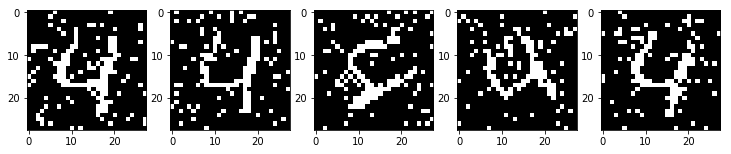

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
case = 4
fig = plt.figure(figsize=(15,8))
for i, image in enumerate(hmnist.test_images[case]):
    fig.add_subplot(1, 6, i+1)
    plt.imshow(image,cmap='gray')
    

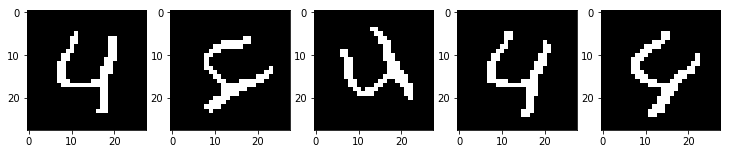

In [18]:
fig = plt.figure(figsize=(15,8))
for i, image in enumerate(hmnist.test_targets[case]):
    fig.add_subplot(1, 6, i+1)
    plt.imshow(image,cmap='gray')

In [19]:
print(hmnist.test_rotations[case])

[  2.42973116 -51.04980853  88.38982625 -44.562548   -22.72210947]


### Adjust the data shape
this part should be different for different model, the q-RNN model does not igorned the sequencial dependency within the dataset, so we don't need to flat the dataset. So that the dataset should be that given a sequence of noisy image $\{p_i\}$ and a sequences of action $\{u_i\}$, the target should be the image of next timestep given action $u_n$

In [20]:
train_X = hmnist.train_images
train_u = hmnist.train_rotations
train_Y = hmnist.train_targets
test_X = hmnist.test_images
test_u = hmnist.test_rotations
test_Y = hmnist.test_targets
print(train_X.shape,train_u.shape,train_Y.shape)
print(test_X.shape,test_u.shape,test_Y.shape)

(60000, 5, 28, 28) (60000, 5) (60000, 5, 28, 28)
(10000, 5, 28, 28) (10000, 5) (10000, 5, 28, 28)


In [21]:
#no adjustment needed

#train_Y = train_Y[:,4,:,:]
#test_Y = test_Y[:,4,:,:]

print(train_X.shape,train_u.shape,train_Y.shape)
print(test_X.shape,test_u.shape,test_Y.shape)

(60000, 5, 28, 28) (60000, 5) (60000, 5, 28, 28)
(10000, 5, 28, 28) (10000, 5) (10000, 5, 28, 28)


In [22]:
device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 0, 'pin_memory': True} if cuda else {}

"""

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)



test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

"""



"\n\ntrain_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('./data', train=True, download=True,\n                   transform=transforms.ToTensor()),\n    batch_size=batch_size, shuffle=True, **kwargs)\n\n\n\ntest_loader = torch.utils.data.DataLoader(\n    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),\n    batch_size=batch_size, shuffle=True, **kwargs)\n\n"

### Dataset object

In [23]:
class HMNISTDataSet():
    def __init__(self, train_img, train_act, train_tar, test_img, test_act, test_tar, test = False, transform=None):
        self.test = test
        self.transform = transform

        if (self.test == False):
          self.images = train_img
          self.targets = train_tar
          self.rotations = train_act

        else:      
          self.images = test_img
          self.targets = test_tar
          self.rotations = test_act

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        if self.transform is not None:
            img = torch.zeros((len(self.images[index]),1,28,28))
            for i in range(len(self.images[index])):
                img[i] = self.transform(self.images[index][i].reshape(28,28,1))
            tar = torch.zeros((len(self.targets[index]),1,28,28))
            for i in range(len(self.targets[index])):
                tar[i] = self.transform(self.targets[index][i].reshape(28,28,1))
                
            rot = torch.tensor(self.rotations[index])
        return img, rot, tar

In [24]:
train_set = HMNISTDataSet(train_X, train_u, train_Y, test_X, test_u, test_Y, test = False, transform = transforms.ToTensor())
test_set = HMNISTDataSet(train_X, train_u, train_Y, test_X, test_u, test_Y, test = True, transform = transforms.ToTensor())

In [25]:
a,b,c = train_set.__getitem__(3)
c.shape


torch.Size([5, 1, 28, 28])

### Create DataLoader

In [26]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)

### Model definition

In [27]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, h_d)
        self.fc2 = nn.Linear(h_d,128)
        self.fc21 = nn.Linear(128, l_d)
        self.fc22 = nn.Linear(128, l_d)
        
        #transition layer
        input_dim = l_d + u_d
        self.rnn_mu = nn.RNN(input_size=input_dim,hidden_size=l_d,batch_first=True)
        self.rnn_sigma = nn.RNN(input_size=input_dim,hidden_size=l_d,batch_first=True)
        
        
        self.fc3 = nn.Linear(l_d, 128)
        self.fc4 = nn.Linear(128,h_d)
        self.fc5 = nn.Linear(h_d, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize1(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def transition(self, z, u):
        rnn_input = torch.cat((z,u),dim=2)
        mu2,_ = self.rnn_mu(rnn_input)
        logvar2,_ = self.rnn_sigma(rnn_input)
        return mu2,logvar2
    
    def reparameterize2(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return torch.sigmoid(self.fc5(h4))

    def forward(self, x, u):
        mu1, logvar1 = self.encode(x.view(-1, 784))
        z1 = self.reparameterize1(mu1, logvar1)
        z1 = z1.reshape(-1,5,32)
        u = u.float()
        mu2, logvar2 = self.transition(z1,u.reshape(-1,5,1))
        z2 = self.reparameterize2(mu2, logvar2)
        
        return self.decode(z2), mu2, logvar2

In [28]:
model = VAE().to(device)
#adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [29]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

### Define training and testing algorithm

In [30]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (img, action, target) in enumerate(train_loader):
        img = img.to(device)
        action = action.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img,action)
        loss = loss_function(recon_batch, target, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #if batch_idx % log_interval == 0:
         #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          #      epoch, batch_idx * len(img), len(train_loader.dataset),
           #     100. * batch_idx / len(train_loader),
            #    loss.item() / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss

In [35]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (img, action, target) in enumerate(test_loader):
            img = img.to(device)
            action = action.to(device)
            target = target.to(device)
            recon_batch, mu, logvar = model(img, action)
            test_loss += loss_function(recon_batch, target, mu, logvar).item()
            if(epoch > epochs - 10):
                if i == 0:
                    n = np.random.randint(0,batch_size)
                    comparison = torch.cat([target[n],
                                          recon_batch.view(batch_size, 5, 1, 28, 28)[n]],dim=0)
                    save_image(comparison.cpu(),
                             'results_rnn_old_test/reconstruction_' + str(epoch) + '.png', nrow=5)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

### Run training

In [32]:
import warnings;
warnings.filterwarnings('ignore')

train_losses = []
test_losses = []
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    with torch.no_grad():
        if(epoch > epochs-10):
            sample = torch.randn(64, l_d).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results_rnn_old_test/sample_' + str(epoch) + '.png')


====> Epoch: 1 Average loss: 1104.1885
====> Test set loss: 1028.5254
====> Epoch: 2 Average loss: 1021.2823
====> Test set loss: 1012.1246
====> Epoch: 3 Average loss: 985.0143
====> Test set loss: 950.1792
====> Epoch: 4 Average loss: 931.6177
====> Test set loss: 912.2539
====> Epoch: 5 Average loss: 902.8930
====> Test set loss: 888.3585
====> Epoch: 6 Average loss: 883.6829
====> Test set loss: 872.7368
====> Epoch: 7 Average loss: 869.5415
====> Test set loss: 860.1476
====> Epoch: 8 Average loss: 858.0272
====> Test set loss: 850.8579
====> Epoch: 9 Average loss: 849.7733
====> Test set loss: 845.9712
====> Epoch: 10 Average loss: 842.6983
====> Test set loss: 839.8256
====> Epoch: 11 Average loss: 837.6835
====> Test set loss: 834.7268
====> Epoch: 12 Average loss: 833.3835
====> Test set loss: 830.6245
====> Epoch: 13 Average loss: 829.4545
====> Test set loss: 829.9037
====> Epoch: 14 Average loss: 825.7699
====> Test set loss: 825.3977
====> Epoch: 15 Average loss: 823.2738


====> Epoch: 119 Average loss: 766.5901
====> Test set loss: 787.3593
====> Epoch: 120 Average loss: 766.1763
====> Test set loss: 787.3212
====> Epoch: 121 Average loss: 766.2079
====> Test set loss: 787.8027
====> Epoch: 122 Average loss: 766.3897
====> Test set loss: 787.0106
====> Epoch: 123 Average loss: 766.4188
====> Test set loss: 788.3455
====> Epoch: 124 Average loss: 766.0563
====> Test set loss: 788.4233
====> Epoch: 125 Average loss: 766.1097
====> Test set loss: 786.1219
====> Epoch: 126 Average loss: 765.1936
====> Test set loss: 787.8603
====> Epoch: 127 Average loss: 765.3518
====> Test set loss: 786.4095
====> Epoch: 128 Average loss: 765.5217
====> Test set loss: 788.3692
====> Epoch: 129 Average loss: 765.6059
====> Test set loss: 790.3953
====> Epoch: 130 Average loss: 764.9229
====> Test set loss: 787.2030
====> Epoch: 131 Average loss: 765.2562
====> Test set loss: 788.0334
====> Epoch: 132 Average loss: 765.2870
====> Test set loss: 787.1225
====> Epoch: 133 Ave

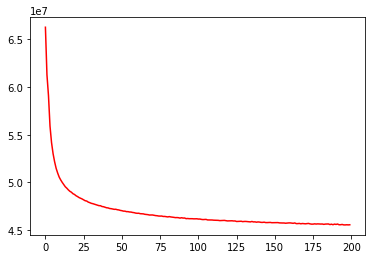

In [33]:
plt.plot(np.array(train_losses),'r')
plt.show()

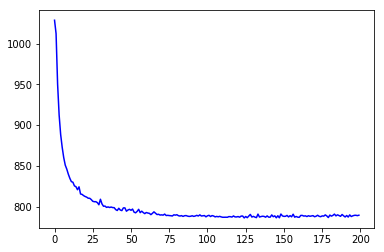

In [34]:
plt.plot(np.array(test_losses),'b')
plt.show()